# Population Regression 
- The goal of this notebook is to assess if population data can be predicted based on temperature data such as UHI phenomena (and other external input such as land cover type, elevation, ...).

In [33]:
#Modules import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import rasterio as rio
import functions as f
import xarray as xr
from importlib import reload
import os
from tqdm import tqdm

## Importing data

We import the dataframe for the 5 european cities of interest containing external factors such as temperature, population, NDVI, land cover type, ...

In [34]:
#Defining parameters

folder_path = 'data_UHI'
cities = ['Lyon']
number_of_sample_per_city = 100000

#read csv
city_df = pd.read_csv('data_UHI/city_df.csv')
city_df.dropna(inplace=True)
city_df.drop(["Unnamed: 0", "pop_cat"], axis = 1, inplace=True)
city_df


,temp,pop,wind,hum,deltaT,hour,month,elevation,city,land cover type,NDVI,isrural,latitude
0,281.45820,173.245821,2.578628,91.793300,-0.197296,8,1,0.0,Amsterdam,22.0,0.692,1.0,52.377956
1,277.59088,1227.491137,1.953275,84.101190,1.419159,6,1,1.0,Amsterdam,22.0,0.616,0.0,52.377956
2,273.18600,1.752613,5.365040,90.277060,0.115814,20,1,-1.0,Amsterdam,22.0,0.852,1.0,52.377956
3,277.83900,10.464526,3.113809,73.838870,0.302155,14,1,-1.0,Amsterdam,31.0,0.848,0.0,52.377956
4,273.96704,5172.893327,2.953496,82.726715,1.439209,7,1,6.0,Amsterdam,1.0,0.416,0.0,52.377956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120876,280.48407,714.744684,1.391384,62.377445,2.148163,4,12,155.0,Vienna,31.0,0.552,1.0,48.208174
2120877,279.47736,61.740572,3.439714,64.843820,1.854706,8,12,158.0,Vienna,32.0,0.500,0.0,48.208174
2120878,271.95370,282.486265,0.401704,94.167250,-0.042053,3,12,151.0,Vienna,31.0,0.620,1.0,48.208174
2120879,279.80844,895.581379,3.410964,67.637910,1.015381,10,12,153.0,Vienna,31.0,0.524,0.0,48.208174


## Data Approach

We split the data between different population to obtain a first overview of the correlation of the heat islands phenomena and the population density. 

In [35]:
df_sample = city_df
#df_sample = city_df[city_df['city'] == 'Vienna']

df_5000 = df_sample[df_sample['pop'] > 5000]

df_2500 = df_sample[df_sample['pop'] < 5000]
df_2500 = df_2500[df_2500['pop'] > 2500]

df_1000 = df_sample[df_sample['pop'] < 2500]
df_1000 = df_1000[df_1000['pop'] > 1000]

df_0 = df_sample[df_sample['pop'] < 1000]
df_0 = df_0[df_0['pop'] > 0]


dfs = [df_sample, df_5000, df_2500, df_1000, df_0]

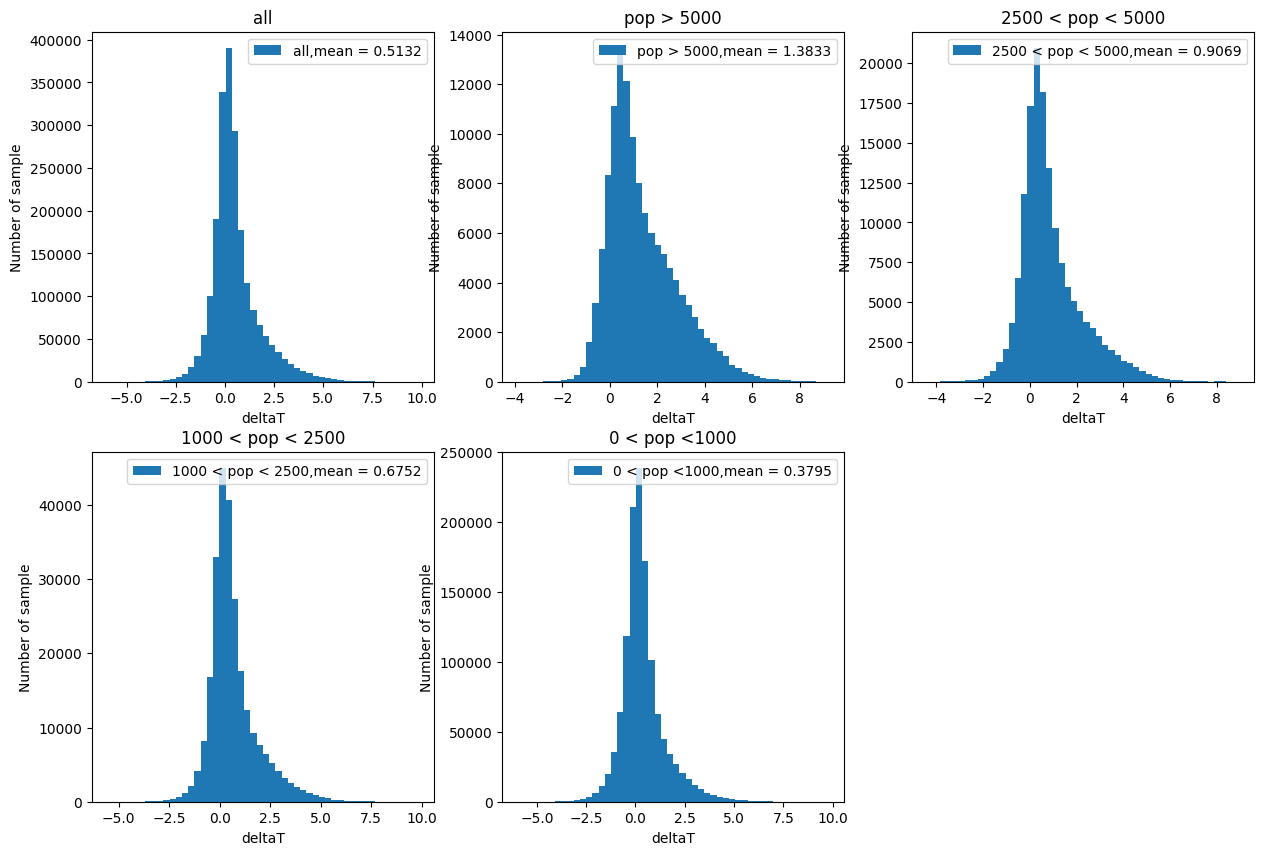

In [36]:
#plot histogram of delta T for all the dataframes with 2 side by side plots
df_legends =   ['all','pop > 5000', '2500 < pop < 5000', '1000 < pop < 2500','0 < pop <1000']
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, df in enumerate(dfs):
    axs[i].hist(df['deltaT'], bins=50, label = df_legends[i] + f',mean = {df["deltaT"].mean():.4f}')
    axs[i].set_title(df_legends[i])
    axs[i].legend()
    axs[i].set_xlabel('deltaT')
    axs[i].set_ylabel('Number of sample')

axs[-1].remove()

It seems there's a correlation between the population density and the deltaT of temperature representing UHI, as we could expect.

## Machine Learning methods

We want to apply a regression to identify the population density based on some external factors. Several different methods from Scikit-learn are used such as MLPRegressor, GradientBoostingRegressor and ExtraTreesRegressor. 

The features on which the analysis is carried upon with are here: temperature, heat islands phenomena, land cover type, NDVI, elevation and latitude.
We restrict the analysis to the urban zone, by choosing only features with 'isrural' == 1.

The data is split between train, test and validation set. 
The data is then scaled, using StandardScaler function from Scikit-learn, which is a preprocessing tool that transforms and scales input data to have a mean of 0 and a standard deviation of 1, ensuring features are on a similar scale for improved model performance.


In [37]:
# Importing the modules
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [38]:
scaler = StandardScaler()
df = dfs[0]
df = df[df['isrural'] == 1]

y = df['pop']
X = df.loc[:,  ['temp', 'deltaT', 'land cover type', 'NDVI', 'elevation', 'latitude']]
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#split the data in training, test, validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train

,temp,deltaT,land cover type,NDVI,elevation,latitude
377764,-0.473587,-0.504838,0.787604,-1.255292,1.678902,-1.508353
600016,-0.027357,0.916866,0.917235,-1.791686,-0.117249,-0.536213
787810,-0.506171,-0.937411,0.787604,0.126953,0.914867,-0.091867
664589,0.390405,0.485476,-0.379080,-0.161874,-0.050229,-0.536213
579412,-0.328781,1.916228,-0.379080,-1.152139,-0.130653,-0.536213
...,...,...,...,...,...,...
810707,-1.580903,-0.029846,0.787604,0.436411,-0.322779,-0.091867
1046540,-0.644152,1.697175,0.787604,0.209475,-0.336183,-0.091867
693615,1.068843,-0.361088,-0.379080,0.415781,-0.108313,-0.536213
946667,2.408070,0.409025,0.787604,0.168214,-0.354055,-0.091867


Different algorithms are tried. The most efficient is the ExtraTreesRegressor() algorithm. 

In [39]:
methods = [MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, activation='relu', solver='adam', random_state=42), GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42), ExtraTreesRegressor(n_estimators=100, random_state=42)]
r2s = []
MSEs = []
for method in methods: 
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    print(method)
    print("MSE: ", mean_squared_error(y_test, y_pred))
    print("R2: ", r2_score(y_test, y_pred))
    MSEs.append(mean_squared_error(y_test, y_pred))
    r2s.append(r2_score(y_test, y_pred))

MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=42)
MSE:  956876.2179793423
R2:  0.4285377811443545
GradientBoostingRegressor(max_depth=10, random_state=42)
MSE:  288053.28869280434
R2:  0.8279698372557843
ExtraTreesRegressor(random_state=42)
MSE:  230830.30883446475
R2:  0.8621443421969079


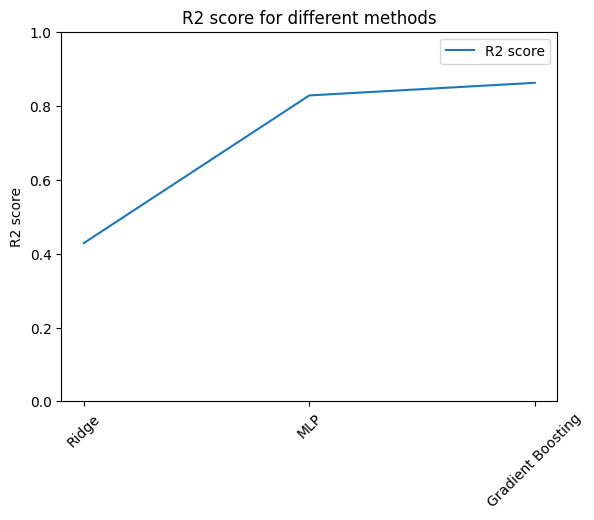

In [41]:
plt.plot(r2s, label = 'R2 score')
plt.ylabel('R2 score')
plt.ylim(0, 1)
plt.xticks(np.arange(3), ('Ridge', 'MLP', 'Gradient Boosting'), rotation = 45)

plt.legend()

plt.title('R2 score for different methods')
plt.show()

We re-run the ExtraTreesRegressor() algorithm and save it in a pickle file.

In [42]:
method =  ExtraTreesRegressor(n_estimators=100, random_state=42)
method.fit(X_train, y_train)
y_pred = method.predict(X_test)
print(method)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

ExtraTreesRegressor(random_state=42)
MSE:  230830.30883446475
R2:  0.8621443421969079


In [ ]:
import pickle 

pickle.dump(method , open('et_model.pk1' , 'wb'))

method = pickle.load(open('et_model.pk1', 'rb'))


### Plots 
Here are the plot of the prediction vs. the actual truth on linear on log-scale. 

C:\Users\broth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\broth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\broth\AppData\Local\Temp\ipykernel_15624\4073252356.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(y_test), np.log10(y_pred), alpha = .1)
C:\Users\broth\AppData\Local\Temp\ipykernel_15624\4073252356.py:8: RuntimeWarning: invalid value encountered in log10
  ax.scatter(np.log10(y_test), np.log10(y_pred), alpha = .1)


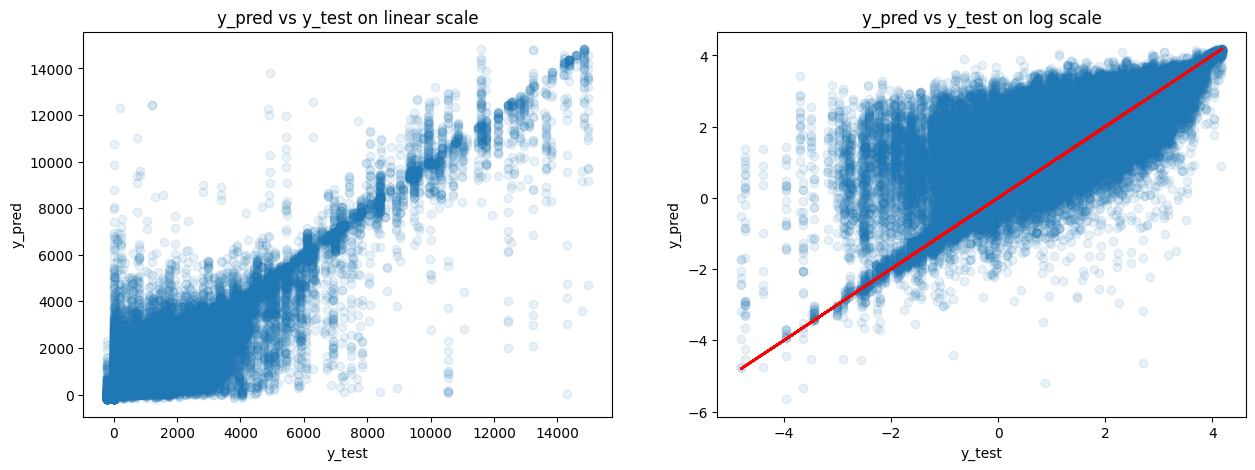

In [44]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha = 0.1)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test on linear scale')
ax = plt.subplot(1, 2, 2)
ax.scatter(np.log10(y_test), np.log10(y_pred), alpha = .1)
ax.plot(np.log10(y_test), np.log10(y_test), color='red')

plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test on log scale')
plt.show()


When working with the dataset with all the cities, we get 0.82 of R2-score, but the most important features are by far elevation, land cover type and NDVI. 

In order to detect this, we use the permutation_importance function from Scikit-Learn, which is a method for evaluating the importance of features in a machine learning model by randomly permuting the values of each feature and measuring the impact on model performance, providing insights into feature contributions.

In [45]:
#Identify which features are the most important for a model 
from sklearn.inspection import permutation_importance
importances = permutation_importance(method, X_val, y_val)
# Order the features by importance 
sorted_idx = importances.importances_mean.argsort()[::-1]
X_train.columns[sorted_idx]

Index(['NDVI', 'land cover type', 'elevation', 'latitude', 'deltaT', 'temp'], dtype='object')

If we now try to training on different cities, we observe that the performances are not equal between each of the cities, neither are the features importance. 

In [46]:
cities = df['city'].unique()
for city in cities:
    df_city = df[df['city'] == city]
    df_city = df_city[df_city['isrural'] == 1]
    y = df_city['pop']
    X = df_city.loc[:,  ['temp', 'deltaT', 'land cover type', 'NDVI', 'elevation', 'latitude']]
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    #split the data in training, test, validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    method =  ExtraTreesRegressor(n_estimators=100, random_state=42)
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    print(city)
    print("MSE: ", mean_squared_error(y_test, y_pred))
    print("R2: ", r2_score(y_test, y_pred))

    # importances = permutation_importance(method, X_val, y_val)
    # Order the features by importance 
    # sorted_idx = importances.importances_mean.argsort()[::-1]
    # print(X_train.columns[sorted_idx])

Amsterdam
MSE:  411517.0760786722
R2:  0.5498339248657844
Madrid
MSE:  466922.18866219366
R2:  0.9276155998020739
Stockholm
MSE:  155689.4863474053
R2:  0.8030663167817751
Lyon
MSE:  58396.88614633064
R2:  0.862739075366781
Vienna
MSE:  123265.60093694612
R2:  0.7942243748580633


### Fine-tuning 
The algorithm still needs to be fine-tuned to optimize the results, but we already obtained an approximation of the population which is quite satisfying.

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = np.linspace(0.1, 1, num = 10)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': sp_randint(10, 150),
               'max_features': [ 'sqrt', 'log2'],
               'max_depth': sp_randint(5, 100),
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(1, 8)}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = ExtraTreesRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter =300 , cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_val, y_val)
rf_random.best_params_


Fitting 3 folds for each of 300 candidates, totalling 900 fits


{'max_depth': 91,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 135}

In [48]:
method =  ExtraTreesRegressor(**rf_random.best_params_)
method.fit(X_train, y_train)
y_pred = method.predict(X_test)
print(method)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

ExtraTreesRegressor(max_depth=91, max_features='sqrt', n_estimators=135)
MSE:  148935.16815505488
R2:  0.7513724258854437
